In [5]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

random.seed(33)

from library.evaluation import ConfusionMatrix

unique_name = "BERT_Finetuned"

In [6]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr2_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [7]:
data = pd.read_csv("../../data/processed/phemernr2_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,label2,topic,tvt,cv_fold,tt,tvt2
0,552833795142209536,The East London Mosque would like to offer its...,non-rumours,non-rumours,charliehebdo-all-rnr-threads,test,2,test,training
1,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,rumours,true,germanwings-crash-all-rnr-threads,training,3,training,training
2,552798891994009601,Reports that two of the dead in the #CharlieHe...,rumours,true,charliehebdo-all-rnr-threads,test,2,test,training
3,576790814942236672,After #Putin disappeared Russian TV no longer ...,non-rumours,non-rumours,putinmissing-all-rnr-threads,test,2,test,training
4,499678822598340608,Saw #Ferguson for myself. #justiceformichaelbr...,non-rumours,non-rumours,ferguson-all-rnr-threads,training,3,training,training


In [8]:
labels_str = data['label2'].unique().tolist()
labels_str

['non-rumours', 'true', 'unverified', 'false']

In [9]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label2'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 1, 1, 0, 0, 0, 0, 2, 0, 0]

In [10]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [11]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4299, 768)
(1471, 768)
(655, 768)
(4299,)
(1471,)
(655,)


In [12]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/media/storage/Work/DataScience/.venv/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
import gym

class DQN(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.ln1 = nn.Linear(n_inputs, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.ln2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.head = nn.Linear(256, 4)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.ln1(x)))
        x = F.relu(self.bn2(self.ln2(x)))
        return self.head(x)

/media/storage/Work/DataScience/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


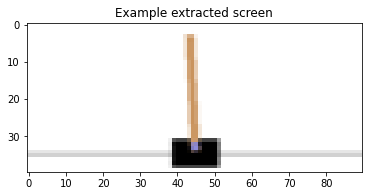

In [15]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = 4

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, label):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    print(action_batch)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [18]:
num_episodes = train_vectors.shape[0]
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    
    # Select and perform an action
    state = train_vectors[i_episode]
    action = select_action(state, [train_labels[i_episode]])
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # Observe new state
    if not done:
        next_state = train_vectors[i_episode + 1]
    else:
        next_state = None

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
    optimize_model()
    if done:
        episode_durations.append(t + 1)
        plot_durations()
        break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()

AssertionError: 2 (<class 'int'>) invalid

In [ ]:
# print("Multiclass Classification using 4-Layer Linear Network")
# start = time.time()
# model_name = f"Phemernr2_multiclass_4LayerNet_{unique_name}"
# model = NNClassifier(train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss)
# model.train_eval(torch.Tensor(train_vectors),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=512)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# print("\nValidation Set")
# preds = model.predict(val_vectors)
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
#     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
#     binary=False,
#     model_name=f"{model_name} Validation"
# )
# conf_mat.evaluate(classes=labels_str)

# print("\nTest Set")
# preds = model.predict(test_vectors)
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
#     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
#     binary=False,
#     model_name=f"{model_name} Test"
# )
# conf_mat.evaluate(classes=labels_str)

In [ ]:
import torch

x = torch.Tensor([[0.345, 0.67, 0.23, 0.45]])
x.max(1)[1].view(1, 1)
x.gather(1, torch.Tensor([[0.35, 0.87, 0.23, 0.45]]).type(torch.int64))